# Experiment 1: Screening Platform

### 📝 Meet our team

You were selected to be a lead medicinal chemist in a critical drug discovery project for our company. Your goal is to find a novel DRD2 inhibitor, which could be used to treat schizophrenia. Your first idea is to buy a lot of diverse molecules found in the ZINC database and verify their biological activity in the lab. ZINC is one of the databases in which you can find small molecules that are available for purchase. Some other databases offer even more molecules that can be synthesized on demand. Let's select a random batch of molecules for testing to get started!

![](assets/lab1.PNG)

### 📘 Glossary

*Dopamine Receptor D$_2$ (DRD2)* - a G protein-coupled receptor that binds dopamine; a common target for antipsychotic drugs.

*High-throughput screening (HTS)* - an experiment in which biological activity is tested automatically for many compounds in parallel.

*Inhibitor* - a molecule that blocks (inhibits) its biological target (usually a protein).

*Library* - a collection of molecules

*Medicinal chemistry* - a branch of chemistry that investigates the interactions between small molecules (or other compounds with potential therapeutic effects) and their biological targets, e.g. to learn how drugs work in the organism; this knowledge is often used to propose new molecules as drug candidates.

*Virtual screening (VS)* - an application of computational tools for finding active compounds in big virtual libraries of compounds.

*ZINC* - a database of readily purchasable compounds that can be used for virtual screening.

### ⚒️ Requesting your first HTS experiment

In [1]:
# 1. Sample random compounds from the ZINC dataset

from src.compound_spaces import SmallZINC
from src.organic import show_molecules
from rdkit import Chem

budget = 1000
library = SmallZINC()
candidates = library.sample(budget)
show_molecules(candidates)

Found local copy...
Loading...
Done!


MolGridWidget()

In [2]:
# 2. Request running HTS on the selected compounds

from src.hts import HighThroughputScreening

hts = HighThroughputScreening()
tested_molecules = hts.test_molecules(candidates)
show_molecules(tested_molecules)

Found local copy...


MolGridWidget()

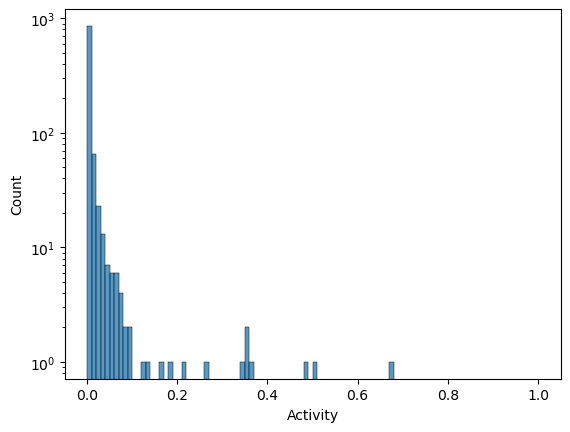

In [3]:
# 3. Show the summary of the screening results

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({'Activity': [mol.activity for mol in tested_molecules]})
sns.histplot(data, binrange=(0, 1), binwidth=0.01, x='Activity', log=True)
plt.show()

# Experiment 2: Automated Generation of Analogs

### 📝 Optimize the discovery process

Our initial screening campaign produced some positive results, but unfortunately, your manager is not satisfied with the cost-to-success ratio. A lot of money was spent on buying compounds and running biochemical assays, but only a few new compounds were found. It is crucial to optimize this process before the company runs out of funding. One possible solution is to use the already tested compounds to build a QSAR model that can aid in your search. Additionally, you can consider modifying the existing compounds to find similar compounds with better activity.

### 📘 Glossary

*Biochemical assay* - a test or an analytical procedure that measures protein binding or activity. 

*ChEMBL* - a public database of molecule activity sourced from publications and patents.

*Molecular fingerprint* - a binary vector that encodes fragments that are included in the molecule; the fragments can be predefined or extracted automatically, e.g. by enumerating substructures around each atom of the molecule.

*Molecular graph* - a graph representation of a molecule, in which atoms are nodes and chemical bonds are edges, attributed with atom features that encode atom types (carbon, oxygen, nitrogen, etc.) and other atomic properties.

*QSAR* - quantitative structure-activity relationship; the name used to describe machine-learning models that predict activity based on the chemical structures at the input.

*Random forest* - a machine-learning model that produces its predictions by combining predictions of multiple decision trees constructed based on the input data; single decision trees perform a sequence of decisions on the input features to maximally separate different data classes (in our case, molecules with different activity labels).

*SELFIES* - a string representation of a molecule that was designed to work better with machine learning algorithms, e.g. by simplifying the grammar of possible molecules compared to SMILES strings and reducing the number of invalid structures.

*SMILES* - a string representation of a molecule that is commonly used to store chemical formulas in databases; in this representation, all atoms of the molecule are encoded by traversing the molecular graph using the DFS order.

### ⚒️ Molecular string representations and simple generative algorithm

Now we need to introduce a method that can optimize our molecules by introducing small structure modifications. We will use the SELFIES representation of molecules (linearized textual representation) that can be easily modified by changing some letters in the representation code. For example, we can change atoms by replacing their symbols in the SELFIES string. We can also add more atoms by adding symbols in the middle of the sequence.


![](assets/lab4.PNG)

In [4]:
from selfies import encoder, decoder
from src.mutate import mutate_selfie
from src.al_loop import LeadCompound
import numpy as np
from src.organic import evaluate_synthesizability


topK_ids = np.argsort([c.activity for c in tested_molecules])[-10:]
print("Mutating top compounds:")
selfies = [encoder(tested_molecules[i].smiles) for i in topK_ids]

mutate_top_k = 10
n_candidates = 100

m = n_candidates // mutate_top_k + 1
new_compounds = []
for i in range(mutate_top_k):
    new_smiles = []
    m_target = min(m, n_candidates - len(new_compounds)) # last batch might be smaller
    while len(new_smiles) != m_target:
        if len(new_compounds) == n_candidates:
            break
        new_smi = decoder(mutate_selfie(selfies[i], max_molecules_len=100)[0])
        if new_smi not in new_smiles and new_smi not in new_compounds:
            new_smiles.append(new_smi)
    new_compounds += new_smiles
assert len(new_compounds) == n_candidates
generated_molecules = hts.test_molecules([Chem.MolFromSmiles(smiles) for smiles in new_compounds])
evaluate_synthesizability(generated_molecules)
show_molecules(generated_molecules)

Mutating top compounds:


Found local copy...


MolGridWidget()

### ⚒️ Molecular property prediction

We will build a simple QSAR model based on the compounds that we tested in our previous experiment. In your other projects, you could also use publicly available data. Databases such as ChEMBL offer a lot of activity data gathered from various online sources.

In the following experiment, we will use Morgan fingerprints to encode molecules. We will use them as an input to a random forest model that predicts the experimental activity. After training this model, we can use it to predict activity without paying for performing biochemical testing in a wet lab.


![](assets/lab2.PNG)

In [12]:
data = pd.DataFrame({
    'activity': [mol.activity for mol in tested_molecules],
    'smiles': [mol.smiles for mol in tested_molecules],
    'synthesizability': [mol.synth_score for mol in tested_molecules],
})

In [13]:
from rdkit.Chem import AllChem
import numpy as np

def calculate_fingerprint(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3)
    return np.array(fingerprint)

data['fingerprint'] = data.smiles.apply(calculate_fingerprint)
data

,activity,smiles,synthesizability,fingerprint
0,0.043316,CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.007019,Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.000299,O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1...,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0.000814,CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.000257,Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1,None,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
995,0.008166,Cc1ccc([C@H]2C3=C(C[C@@H](c4ccccc4Cl)CC3=O)Nc3...,None,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
996,0.002269,COCCS[C@@H]1C[C@H](C)CC[C@H]1C#N,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
997,0.000012,Cc1ccc(S[C@H](C)C(=O)N2CCC[C@@H](C(N)=O)C2)cc1,None,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
998,0.000903,COCCN(C)C(=O)[C@H]1COc2ccc(F)cc2C1,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


In [25]:
from sklearn.ensemble import RandomForestRegressor

X_data, y_data = np.stack(data.fingerprint), data.activity
X_train, y_train = X_data[:900], y_data[:900]
X_test, y_test = X_data[900:], y_data[900:]
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

ρ =  0.39846384638463844


<Axes: xlabel='preds', ylabel='labels'>

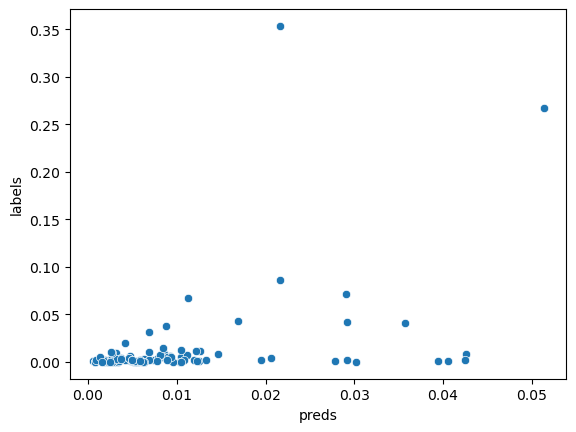

In [48]:
df_preds = pd.DataFrame({'preds': model.predict(X_test), 'labels': y_test})
corr = df_preds.corr('spearman').iloc[1, 0]
print("ρ = ", corr)
sns.scatterplot(data=df_preds, x='preds', y='labels')

### ⚒️ Using molecular property prediction in the generative model

In [ ]:
if self.n_iterations < self.n_warmup_iterations:
    return self.base_loop.propose_candidates(n_candidates)

previous_results: List[LeadCompound] = self.load()
self._train_model(previous_results)
X_test = self._featurize([c.smiles for c in candidates])
y_pred = self._model.predict_proba(X_test)[:, 1]
return [c for _, c in sorted(zip(y_pred, candidates), reverse=True, key=lambda a: a[0])][:n_select]
return self._select_top_N(self.base_loop.propose_candidates(10 * n_candidates), n_candidates)

### ⚒️ Side project: graph neural networks

![](assets/lab3.PNG)

In [ ]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


class GraphFeaturizer:
    def __call__(self, df: pd.DataFrame):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            
            edges = []
            for bond in mol.GetBonds():
                ...  # TODO: Add edges in both directions
            edges = np.array(edges)
            
            nodes = []
            for atom in mol.GetAtoms():
                results = ...  # TODO: Add atom features as a list, you can use one_of_k_encodings defined above
                nodes.append(results)
            nodes = np.array(nodes)
            
            graphs.append((nodes, edges.T))
            labels.append(y)
        labels = np.array(labels)
        return [Data(
            x=torch.FloatTensor(x), 
            edge_index=torch.LongTensor(edge_index), 
            y=torch.FloatTensor([y])
        ) for ((x, edge_index), y) in zip(graphs, labels)]

In [ ]:
def train(train_loader, valid_loader):
    # hyperparameters definition
    hidden_size = 512
    epochs = 10
    learning_rate = 0.0001
    
    # model preparation
    model = GraphNeuralNetwork(hidden_size)  # TODO: you can add more hyperparameters if needed
    model.train()
    
    # training loop
    optimizer = ... # TODO: define an optimizer
    loss_fn = ...  # TODO: define a loss function
    for epoch in trange(1, epochs + 1, leave=False):
        for data in tqdm(train_loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            model.zero_grad()
            preds = model(x, edge_index, batch)
            loss = loss_fn(preds, y.reshape(-1, 1))
            loss.backward()
            optimizer.step()
    return model


def predict(model, test_loader):
    # evaluation loop
    preds_batches = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            
            preds = model(x, edge_index, batch)
            preds_batches.append(preds.cpu().detach().numpy())
    preds = np.concatenate(preds_batches)
    return preds


# training
model = train(train_loader, valid_loader)

# evaluation
predictions = predict(model, test_loader)

rmse_score = rmse(y_test, predictions.flatten())

print(f'RMSE = {rmse_score:.2f}')
assert rmse_score < 1.4, "It should be possible to obtain RMSE lower than 1.4"
print('Looks OK!')

# Experiment 3: Comparison of Random and Targeted Screening Results

1. Evaluation metrics
2. visualization tools (seaborn, chemwidgets)
3. Exploration vs Exploitation

### 📝 Report your new findings

Congratulations! You found several novel molecules that are very promising! Now, you need to convince the stakeholders that your approach is highly efficient. Let's compare our new hits with random molecules sampled from ZINC.

### 📘 Glossary

*Hits* -

### Comparison between random samples and generated molecules

In [11]:
show_molecules(tested_molecules)

MolGridWidget()

In [10]:
show_molecules([LeadCompound(smiles=c) for c in new_compounds])

MolGridWidget()

### Showing molecular structures

# Experiment 4: Closing the Loop with Active Learning

### 📝 Automate the process

Your reports drew the attention of stakeholders, and now the company asks you if you can automate this process to mine new hits given a specific project budget. Let's try to close the loop and use all the experiments performed so far to improve our predictive models and sample new hits. Remember that while it's important to use prior knowledge about your hits and exploit similar structures, it is also important to gain new knowledge by exploring undiscovered parts of the chemical space. Good luck! 

### 📘 Glossary

In [4]:
separate tokens / other targets

SyntaxError: invalid syntax (2099591849.py, line 1)

In [5]:
import sklearn

sklearn.__version__

'1.3.1'